## MEPS Dataset Analysis

So we have two files - one with basic demographic info and one with medications. They're small and pandas will deal with them fine - no need for SQL in an offline analysis setting. We'll just want to join them on id to make predictions.

Some obvious things to keep in mind from looking at them -  
1) a significant proportion of subjects are younger than sixteen. For these individuals, we have basically zero info - best to drop them from our tables and not make predictions for them. A cursory search of meds reveals no medication info for them.  
2) We have tons of duplicate meds - we'll probably want to consolidate these. 

Since this is an informal ad hoc analysis, I'll just be checking results of operations rather than building out proper tests. Of course, this isn't intended to look like production code :)

In [2]:
# coding=utf-8
# python = 2.7.x, since most companies still use that, but I'll keep the code 3.x compatible where possible

import numpy as np
import pandas as pd
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.dummy import DummyRegressor


pd.options.display.max_columns = 50
sns.set_palette('pastel')
%matplotlib inline

subjects = pd.read_csv("./input/meps_base_data.csv")
meds = pd.read_csv("./input/meps_meds.csv")


def display_summary(dfs_to_describe, preview_size=5):
    print("\n\n Summary of data: \n\n")
    
    for df in dfs_to_describe:

        print("Preview: ")
        print(df.head(preview_size))
        print("\n\n Stats: ")
        print(df.describe())
        print("\n\n")

    
display_summary([subjects,meds])



 Summary of data: 


Preview: 
   Unnamed: 0        id  panel  pooledWeight  age     sex      race  \
0           1  10007101     15   3603.881236   28    Male     White   
1           2  10007102     15   2544.550424   25  Female     White   
2           3  10007103     15   4050.397468    4    Male     White   
3           4  10007104     15   3064.059720    3  Female     White   
4           5  10008101     15   3635.552466   51    Male  Multiple   

                   married highBPDiagnosed diabetesDiagnosed  chdDiagnosed  \
0                  MARRIED             Yes                No            No   
1                  MARRIED              No                No            No   
2  UNDER 16 - INAPPLICABLE    Inapplicable      Inapplicable  Inapplicable   
3  UNDER 16 - INAPPLICABLE    Inapplicable      Inapplicable  Inapplicable   
4                  MARRIED              No                No            No   

    miDiagnosed anginaDiagnosed strokeDiagnosed emphysemaDiagnosed  \
0

### Data Cleanup  

Let's think about what data we can drop -  

1) from our subjects,  
    a) `panel` seems to be panel year and is unlikely to be terribly useful to us, at least for now. With a sufficiently large amount of data, it could be used in tree algorithms and the like as-is. Or we could subdivide by groups of years and treat as a categorical so that a classifier could find trends for each period of time bin.  
    b) `pooledWeight` seems to be used for a weighting function / to correct for demographics. I couldn't immediately find details on how to use the weighting function, so I'm ignoring it for now.  
    
2)  from our medications
    a) we have tons of duplicates of drugs - presumably we have one record per prescription written; let's just keep one record of a prescription of a given drug per person (we'll assume that they've stayed on it)  
    b) right now, let's drop a few columns - rxNDC is apparently a "NATIONAL DRUG CODE (IMPUTED)"; this might initially seem useful, but it actually isn't because there are multiple codes for many drugs    
    
Let's also drop `rxStartMonth` - we could use this and rxStartYear to build a more standardized datetime scheme (ignoring that months are missing very frequently), but for now let's just use year; year could be useful - lets us control for differing prescriptions used to treat diseases as medicine progresses.  


In [8]:
# Define a simple drop function.
def drop_cols(df, cols):
    # Find which cols in requested list are present.
    cols_drop = list(set(df.columns) & set(cols))
    if not cols_drop:
        print('No cols found to drop.')
    else:
        # Inplace to avoid namespace/scope issues.
        df.drop(cols, axis='columns', inplace=True)
        
# Drop fields mentioned above.
drop_cols(subjects,['Unnamed: 0', 'panel','pooledWeight'])
drop_cols(meds,['Unnamed: 0', 'rxNDC','rxStartMonth'])

# Drop individuals younger than 16.
younglings = subjects[subjects.age < 16].index
try: subjects.drop(younglings, axis=0, inplace=True)
except ValueError: print('Already dropped underage subjects.')

# Impute mean prescription year for prescriptions with invalid years (e.g -8).  
valid_by_year = meds[meds.rxStartYear > 1900]
avg_rx_year = valid_by_year.rxStartYear.mean()
# Apply that value to prescriptions with invalid years.  
meds.loc[meds.rxStartYear < 1900] = avg_rx_year

meds.drop_duplicates(subset = ['id','rxName'], inplace=True)

display_summary([subjects,meds])

No cols found to drop.
No cols found to drop.


 Summary of data: 


Preview: 
         id  age     sex      race        married highBPDiagnosed  \
0  10007101   28    Male     White        MARRIED             Yes   
1  10007102   25  Female     White        MARRIED              No   
4  10008101   51    Male  Multiple        MARRIED              No   
5  10008102   53  Female     Asian        MARRIED              No   
7  10009101   61  Female     Black  NEVER MARRIED             Yes   

  diabetesDiagnosed chdDiagnosed miDiagnosed anginaDiagnosed strokeDiagnosed  \
0                No           No          No              No              No   
1                No           No          No              No              No   
4                No           No          No              No              No   
5                No           No          No              No              No   
7                No           No          No              No              No   

  emphysemaDiagnosed asth

#### JOIN

I'm going to inner join, so we keep all prescriptions for people who we have demographic info.  
It would also be reasonable to left join so that we keep info on all people even if they don't have any prescriptions. I went ahead and also tried a left join, and it only affected the number of subjects pretty marginally (by <10%).

In [9]:
subj_and_meds = pd.merge(subjects, meds, how='inner', on='id', sort=True)
print('Cols before merge:')
print(subjects.columns.values)
print(meds.columns.values)
print('Cols after merge:')
print(subj_and_meds.columns.values)
print(subj_and_meds.shape)

Cols before merge:
['id' 'age' 'sex' 'race' 'married' 'highBPDiagnosed' 'diabetesDiagnosed'
 'chdDiagnosed' 'miDiagnosed' 'anginaDiagnosed' 'strokeDiagnosed'
 'emphysemaDiagnosed' 'asthmaDiagnosed' 'otherHDDiagnosed'
 'heartFailureDiagnosed']
['id' 'rxStartYear' 'rxName' 'rxQuantity' 'rxForm']
Cols after merge:
['id' 'age' 'sex' 'race' 'married' 'highBPDiagnosed' 'diabetesDiagnosed'
 'chdDiagnosed' 'miDiagnosed' 'anginaDiagnosed' 'strokeDiagnosed'
 'emphysemaDiagnosed' 'asthmaDiagnosed' 'otherHDDiagnosed'
 'heartFailureDiagnosed' 'rxStartYear' 'rxName' 'rxQuantity' 'rxForm']
(169868, 19)


In [24]:
# Visually inspect result of JOIN to make sure it worked as expected.
# subj_and_meds.to_csv("joined_data.csv")

### Variable Encoding  

We currently don't have much of our info in an easily-interpretable form for our model(s) - we'll want to re-encode a whole bunch of categorial variables -  

1) We need to turn our sex column and diagnoses into a boolean value - e.g. "isFemale"   
2) We need to one-hot encode race and married. (If we were ignoring logisitic regression and its kin, factorizing with e.g. pd.factorize() would also work and would result in a slightly smaller memory footprint and faster model training for tree-based models.)  
 

In [11]:
# Start with re-encoding sex.

try: subj_and_meds['isFemale'] = subj_and_meds.sex == "Female"
except AttributeError: print("isFemale already created. Skipping.")
drop_cols(subj_and_meds, ['sex'])

print('Example of diagnosis col before value correction:')
print(subj_and_meds.diabetesDiagnosed.iloc[:5])

# Now we'll re-encode all the diagnoses.
# or == True so I can run this code multiple times without getting glitches
# (Don't want to force you to restart the notebook if you run a cell twice.)
yn_to_bool = lambda value: value == "Yes" or value == True 
diagnoses = ['highBPDiagnosed', 'diabetesDiagnosed', 'chdDiagnosed', 'miDiagnosed', 'anginaDiagnosed',
             'strokeDiagnosed', 'emphysemaDiagnosed', 'asthmaDiagnosed', 'otherHDDiagnosed', 'heartFailureDiagnosed']
# for diagnosis in diagnoses:
#     subj_and_meds[diagnosis] = subj_and_meds[diagnosis].apply(yn_to_bool)
subj_and_meds[diagnoses] = subj_and_meds[diagnoses].applymap(yn_to_bool)

print('\n Example of diagnosis col after value correction:')
print(subj_and_meds.diabetesDiagnosed.iloc[:5])
    
print('\n Cols incl. newly-created bools:')
print(subj_and_meds.columns)


# For the sake of code cleanliness, I'll create both sets here, but you could argue that 
# I should create them separately to have more descriptive variable names (e.g. "race_"
# and "marital_" prefixes rather than "d_")
try: 
    subj_and_meds = pd.get_dummies(subj_and_meds, columns = ['race', 'married'], prefix='d_')
except ValueError: 
    print("Couldn't find dummy sources - likely already created.")
print('Columns including one-hot encoded cols: ')
print(subj_and_meds.columns)


print("\n\n Now including dummies: \n\n")
drop_cols(subj_and_meds, ['race', 'married'])
print(subj_and_meds.columns)
print(subj_and_meds.head(3))

isFemale already created. Skipping.
No cols found to drop.
Example of diagnosis col before value correction:
0    False
1    False
2    False
3    False
4    False
Name: diabetesDiagnosed, dtype: bool

 Example of diagnosis col after value correction:
0    False
1    False
2    False
3    False
4    False
Name: diabetesDiagnosed, dtype: bool

 Cols incl. newly-created bools:
Index([u'id', u'age', u'highBPDiagnosed', u'diabetesDiagnosed',
       u'chdDiagnosed', u'miDiagnosed', u'anginaDiagnosed', u'strokeDiagnosed',
       u'emphysemaDiagnosed', u'asthmaDiagnosed', u'otherHDDiagnosed',
       u'heartFailureDiagnosed', u'rxStartYear', u'rxName', u'rxQuantity',
       u'rxForm', u'isFemale', u'd__Amer Indian/Alaska Native', u'd__Asian',
       u'd__Black', u'd__Multiple', u'd__Native Hawaiian/Pacific Islander',
       u'd__White', u'd__DIVORCED', u'd__DIVORCED IN ROUND', u'd__MARRIED',
       u'd__MARRIED IN ROUND', u'd__NEVER MARRIED', u'd__SEPARATED',
       u'd__SEPARATED IN ROUND', u

In [26]:
# visually inspect result of concat above to make sure it worked as expected
# subj_and_meds.to_csv("with_dummies.csv")

I noticed that we have categories that we might want to merge - e.g. "widowed in round" is pretty rare and should, perhaps, be merged into "widowed."  
One other caveat - we have no default for our dummy variables, which will cause multicollinearity issues with regression models - we should fix this later if we want to use them.

## Let's actually do some analyses :)

#### 1) What are the most common medications for each disease?

In [14]:
# TODO: this could be expressed in a more efficient manner as a .groupby(), 
#   although I think the for may be more readable.
# Also, you'd have to convert the one-hot-encoded diseases into a single categorical column, 
#   and handling individuals with multiple diseases would be a pain.

for diagnosis in diagnoses:
    current_diagnosis = subj_and_meds[subj_and_meds[diagnosis] == True]
    print("\n\n For diagnosis %s, most common prescription is: \n" % diagnosis)
    print(current_diagnosis['rxName'].describe())



 For diagnosis highBPDiagnosed, most common prescription is: 

count          93623
unique          5650
top       LISINOPRIL
freq            2476
Name: rxName, dtype: object


 For diagnosis diabetesDiagnosed, most common prescription is: 

count         40116
unique         3823
top       METFORMIN
freq           1158
Name: rxName, dtype: object


 For diagnosis chdDiagnosed, most common prescription is: 

count          22039
unique          2867
top       LISINOPRIL
freq             466
Name: rxName, dtype: object


 For diagnosis miDiagnosed, most common prescription is: 

count          14725
unique          2333
top       LISINOPRIL
freq             339
Name: rxName, dtype: object


 For diagnosis anginaDiagnosed, most common prescription is: 

count          11603
unique          2164
top       LISINOPRIL
freq             194
Name: rxName, dtype: object


 For diagnosis strokeDiagnosed, most common prescription is: 

count          14319
unique          2464
top       LISINOP

Gut check - lisinopril is an ACE inhibitor, and ACE inhibitors are a frontline treatment for hypertension. Metformin is a frontline treatment for type 2 diabetes (and type 2 is far more common than type 1).

#### 2) Which medications are most indicative of each disease?

Let's figure out which drug is the most specific for each disease. So I'll calculate:

instances of drug for disease / instances of drug overall

In other words, I'm getting the precision of a given drug in making a diagnosis for a given disease.

One caveat: if we have drugs with exceedingly low counts - say one doctor has homeopathic leanings and prescribes a diabetic patient ginseng - it could seemingly be a perfect identifier by this metric. Instead, I'll only look at the drugs that are reasonably common - using exceedingly rare drugs to diagnoses common diseases seems like it would only be marginally useful, anyway. 

In [16]:
# We'll take our list of prescriptions, and get their counts.
# All of our most common drugs per diagnosis above have high frequencies (>1000), 
#   but I'll go ahead and grab the top 100 to be safe.
# Use counts as the index, so we have them sorted by descending frequency.
# Using function-chaining syntax here. I find it pretty readable, but some people don't.
drugs = (
    subj_and_meds['rxName']
        # Get value_counts() for drugs - it's sorted and descending by default, 
        # but I've specified them as kwargs for maximum explicitness.
        .value_counts(sort=True, ascending=False)  
        # Get the top 100 most-common.
        .iloc[0:100]
        .reset_index(drop=False)
)

# Fix column names.
drugs.rename(columns={'index': 'rxName', 'rxName': 'count'}, inplace=True)

# Confirm size of list.
print('# of drugs extracted:')
print(drugs.rxName.size)
print('')
# Confirm that our most common drugs are here, indexed by count.
print("Most common drugs that we've extracted:")
print(drugs.head(10))
print("Least common drugs that we've extracted:")
print(drugs.tail(10))

# of drugs extracted:
100
Most common drugs that we've extracted:
         rxName  count
0  AZITHROMYCIN   3358
1    LISINOPRIL   2865
2   AMOXICILLIN   2687
3   SIMVASTATIN   2312
4     IBUPROFEN   2243
5    PREDNISONE   1712
6  HYDROCO/APAP   1703
7       LIPITOR   1630
8    OMEPRAZOLE   1496
9     METFORMIN   1422
Least common drugs that we've extracted:
                       rxName  count
90                 LORATADINE    309
91               ADVAIR DISKU    308
92             APAP/OXYCODONE    306
93                 DIOVAN HCT    303
94                GLIMEPIRIDE    302
95                 SMZ/TMP DS    302
96               PENICILLN VK    294
97      ACETAMINOPHEN/CODEINE    294
98         PRAVASTATIN SODIUM    293
99  SIMVASTATIN (FILM-COATED)    293


In [25]:
drug_precisions = list()

# Iterate through each dx and each drug - O(n^2)
# There's plenty of room to optimize this code if it gets run frequently
for drug in drugs.rxName:
    # get number of users for the drug
    users = float(subj_and_meds[subj_and_meds['rxName'] == drug]['rxName'].size)
    # checked that these counts are equal to the counts above - commented it out now
    for diagnosis in diagnoses:
        # get number of users of the drug who have the diagnosis
        fil_dx_and_rx = ((subj_and_meds[diagnosis] == True) & (subj_and_meds['rxName'] == drug))
        users_with_dx = subj_and_meds[fil_dx_and_rx]['rxName'].size
        this_precision = users_with_dx / users
        drug_precisions.append({'rxName': drug, 'diagnosis': diagnosis, 'precision': this_precision})
        
# print(drug_precisions)


[{'rxName': 'AZITHROMYCIN', 'diagnosis': 'highBPDiagnosed', 'precision': 0.3356164383561644}, {'rxName': 'AZITHROMYCIN', 'diagnosis': 'diabetesDiagnosed', 'precision': 0.09767718880285885}, {'rxName': 'AZITHROMYCIN', 'diagnosis': 'chdDiagnosed', 'precision': 0.0604526503871352}, {'rxName': 'AZITHROMYCIN', 'diagnosis': 'miDiagnosed', 'precision': 0.0357355568790947}, {'rxName': 'AZITHROMYCIN', 'diagnosis': 'anginaDiagnosed', 'precision': 0.033948779035139966}, {'rxName': 'AZITHROMYCIN', 'diagnosis': 'strokeDiagnosed', 'precision': 0.034544371649791544}, {'rxName': 'AZITHROMYCIN', 'diagnosis': 'emphysemaDiagnosed', 'precision': 0.034544371649791544}, {'rxName': 'AZITHROMYCIN', 'diagnosis': 'asthmaDiagnosed', 'precision': 0.14740917212626564}, {'rxName': 'AZITHROMYCIN', 'diagnosis': 'otherHDDiagnosed', 'precision': 0.11465157832042883}, {'rxName': 'AZITHROMYCIN', 'diagnosis': 'heartFailureDiagnosed', 'precision': 0.011911852293031567}, {'rxName': 'LISINOPRIL', 'diagnosis': 'highBPDiagnose

In [38]:
# Convert list of dict rows to pd.DataFrame. 
# (Want to do this all at once since extending a DataFrame is an expensive operation.)
precisions = pd.DataFrame(drug_precisions)
print(precisions.head(5))

           diagnosis  precision        rxName
0    highBPDiagnosed   0.335616  AZITHROMYCIN
1  diabetesDiagnosed   0.097677  AZITHROMYCIN
2       chdDiagnosed   0.060453  AZITHROMYCIN
3        miDiagnosed   0.035736  AZITHROMYCIN
4    anginaDiagnosed   0.033949  AZITHROMYCIN


In [40]:
# Now get the max precision for each diagnosis. 
# It would be cleaner to just groupby diagnosis and get the max precision,
#   but that wouldn't yield the drug name for each max.
# Instead, we'll sort our precisions and then take the max for each diagnosis.

sorted_ = precisions.sort_values(by='precision')
max_precisions = sorted_.drop_duplicates('diagnosis', keep='last').sort_values(by='precision')
print(max_precisions)

                 diagnosis  precision        rxName
669  heartFailureDiagnosed   0.204188    CARVEDILOL
916     emphysemaDiagnosed   0.211039  ADVAIR DISKU
324        anginaDiagnosed   0.296117        PLAVIX
325        strokeDiagnosed   0.307443        PLAVIX
323            miDiagnosed   0.401294        PLAVIX
322           chdDiagnosed   0.529126        PLAVIX
698       otherHDDiagnosed   0.552632      WARFARIN
917        asthmaDiagnosed   0.675325  ADVAIR DISKU
501      diabetesDiagnosed   0.965591         ACTOS
930        highBPDiagnosed   0.970297    DIOVAN HCT


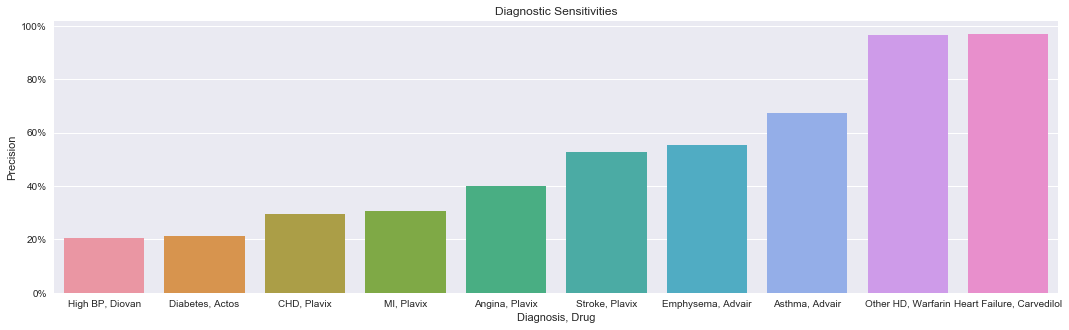

In [42]:
%matplotlib inline

# FIXME!

formatted_dx = ['High BP, Diovan', 'Diabetes, Actos', 'CHD, Plavix', 'MI, Plavix',
                'Angina, Plavix', 'Stroke, Plavix', 'Emphysema, Advair', 'Asthma, Advair',
                'Other HD, Warfarin', 'Heart Failure, Carvedilol']

plt.figure(figsize=(18,5))
plt.title('Diagnostic Sensitivities')

ax = sns.barplot(x=max_precisions.diagnosis, y=max_precisions.precision, data=precisions)
ax.set_ylabel("Precision"); ax.set_xlabel("Diagnosis, Drug")
ax.set_xticklabels(formatted_dx)
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

plt.show()

Gut check - these make sense - Diovan HCT is a combo ACE inhibitor and diuretic, two extremely common classes of drugs for high blood pressure; Plavix is an anticoagulant, so it's used for various heart diseases; advair is a bronchodilator, so it's used for respiratory disorders.

#### 3) Let's model one disease.

First we have to pick a disease. If I want to pick one that's easy to model, it would be nice to choose one that has lots of instances and that is also well-distinguished by a small number of criteria. As you can see below, HBP would be an obvious choice, but HBP is really common, even in people who are mostly healthy. It would be cool to train a more complex model on it, but for the sake of simplicity, I'll model diabetes, which is a classic stats/ML problem. 

By the way, with regards to model performance, we probably care more about recall than precision in this instance - we really want to pick up cases of the disease based on medicines and don't care all that much if we falsely flag the potential presence of a disease. Also, raw accuracy isn't far off from worthless, since (most) of these disease are pretty rare. Diabetes affects around 10% of people in a random sample of Americans, so a model that predicts y=0 is 90% accurate in a random samples (and 74% accurate in our sample - our sample isn't a random sample of Americans, as we'll soon find out).

In [48]:
# Let's pick.
# Again, syntax here is slightly awkward because of one-hot encoded 
#   disease columns and potential for each subject to have multiple 
#   diagnoses.
for diagnosis in diagnoses:
    subj_with_dx = (
        subj_and_meds
            .groupby([diagnosis])  # For this diagnosis, True or False
            .id  # Arbitrary column to count.
            .count()  # Take the count.
            [True]  # Only care about the count that have this disease.
    )
    print('Number of subjects with %s:' % diagnosis)
    print(subj_with_dx)

Number of subjects with highBPDiagnosed:
93623
Number of subjects with diabetesDiagnosed:
40116
Number of subjects with chdDiagnosed:
22039
Number of subjects with miDiagnosed:
14725
Number of subjects with anginaDiagnosed:
11603
Number of subjects with strokeDiagnosed:
14319
Number of subjects with emphysemaDiagnosed:
9594
Number of subjects with asthmaDiagnosed:
28376
Number of subjects with otherHDDiagnosed:
31770
Number of subjects with heartFailureDiagnosed:
4940
Number with disease highBPDiagnosed = 93623
Number with disease diabetesDiagnosed = 40116
Number with disease chdDiagnosed = 22039
Number with disease miDiagnosed = 14725
Number with disease anginaDiagnosed = 11603
Number with disease strokeDiagnosed = 14319
Number with disease emphysemaDiagnosed = 9594
Number with disease asthmaDiagnosed = 28376
Number with disease otherHDDiagnosed = 31770
Number with disease heartFailureDiagnosed = 4940


In [50]:
diabetes_df = subj_and_meds.copy()

# Drop other diagnoses from the set - while it would be lovely to have diagnosis info
#   for the other diseases to train our model, it's not terribly realistic.
other_diag = [diag for diag in diagnoses if diag is not 'diabetesDiagnosed']
drop_cols(diabetes_df, other_diag)
print(diabetes_df.columns)

No cols found to drop.
Index([u'id', u'age', u'diabetesDiagnosed', u'rxStartYear', u'rxName',
       u'rxQuantity', u'rxForm', u'isFemale', u'd__Amer Indian/Alaska Native',
       u'd__Asian', u'd__Black', u'd__Multiple',
       u'd__Native Hawaiian/Pacific Islander', u'd__White', u'd__DIVORCED',
       u'd__DIVORCED IN ROUND', u'd__MARRIED', u'd__MARRIED IN ROUND',
       u'd__NEVER MARRIED', u'd__SEPARATED', u'd__SEPARATED IN ROUND',
       u'd__WIDOWED', u'd__WIDOWED IN ROUND'],
      dtype='object')


In [51]:
diabetes_df['diabetesDiagnosed'].describe()

# We have (169868-129752)/169868 = 23.6% with diabetes in our sample; 
#   this is more than 2x the population proportion!
# In our sample, diabetesDiagnosed=True isn't a terribly rare class.
#   (But we should still be wary of class imbalance.)

count     169868
unique         2
top        False
freq      129752
Name: diabetesDiagnosed, dtype: object

#### Do our non-drug variables carry interesting information?

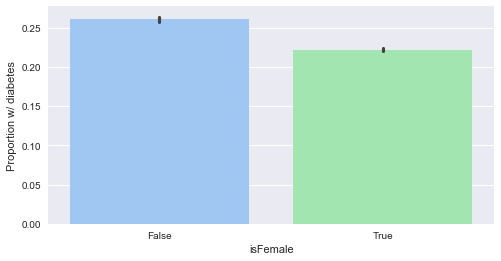

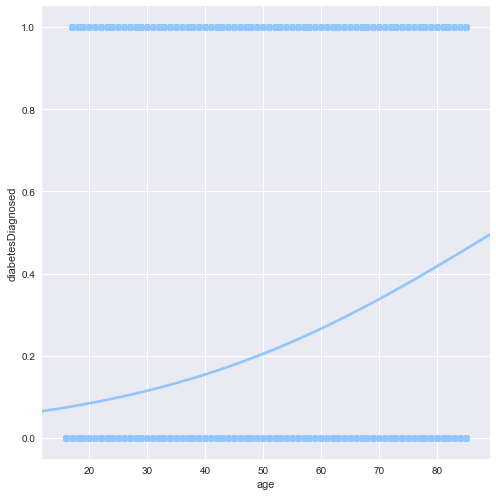

In [56]:
plt.figure(figsize=(8,4))

# let's see if our other fields have any useful info...
ax = sns.barplot('isFemale','diabetesDiagnosed', data=diabetes_df)
ax.set_ylabel('Proportion w/ diabetes')

# Below regression takes around a while to run - feel free to comment out this code
# it just shows diabetes incidence increases pretty dramatically with age.
# This isn't exactly shocking :)
sns.lmplot(x='age', y='diabetesDiagnosed', data=diabetes_df, size=7, logistic=True, n_boot=80, ci=5)

Let's make our train-test split - 100k+ rows so we have a good amount of data. Of course, we'l use cross-validation to get the most out of our training data.

In [61]:
# For now, drop our qualitative variables - obviously there's a tremendous amount of info
#   in rxName, so we'll want to add them back later.
dropped_qual = diabetes_df.copy().drop(['rxName', 'rxForm'], axis=1)

# TODO: refactor train-test split into function; 
# we'll still need the variables as globals so we can refer to them outside the function.

# Split training and test
# Large dataset (>100k rows), so 20% should be adequate for our test.
# Since we have a nontrivial class imbalance, we'll want to stratify on our outcome.
# (Of course, it's best practice to always stratify classification outcomes.)
all_x = dropped_qual.copy().drop(['diabetesDiagnosed'], axis=1)
all_y = dropped_qual.copy()['diabetesDiagnosed']

X_train, X_test, Y_train, Y_test = train_test_split(
    all_x, all_y, test_size=.2, random_state=2001, stratify=all_y.values)

for dataset in [X_train, X_test, Y_train, Y_test]:
    print("\nDataset --> \n")
    print(dataset.head(3))
    


Dataset --> 

              id  age  rxStartYear  rxQuantity  isFemale  \
147565  85146101   59       2008.0        90.0      True   
1231    10255101   66       2010.0        60.0     False   
152541  86112101   61       2008.0        10.0      True   

        d__Amer Indian/Alaska Native  d__Asian  d__Black  d__Multiple  \
147565                             0         0         0            0   
1231                               0         0         0            0   
152541                             0         0         0            1   

        d__Native Hawaiian/Pacific Islander  d__White  d__DIVORCED  \
147565                                    0         1            0   
1231                                      0         1            0   
152541                                    0         0            0   

        d__DIVORCED IN ROUND  d__MARRIED  d__MARRIED IN ROUND  \
147565                     0           0                    0   
1231                       0           1

#### Split our train and test sets

#### Logistic Regression
We're doing this to gain some insight into the underlying correlates of diabetes, not because it'll be an ideal model. (It won't.)

In [62]:
# TODO: change model to sklearn.linear_model.LogisticRegressionCV
# We'll use SciKit-Learn's LogisticRegressionCV model. 
# It uses CV to set its regularization strengths.

# logistic = LogisticRegression(random_state=2001, solver='liblinear', class_weight='balanced', n_jobs=-1)
logistic = LogisticRegressionCV(random_state=2001, solver='liblinear', class_weight='balanced', n_jobs=-1)


# Need to normalize for a logistic regression's coefficients to be meaningful.
diabetes_norm = dropped_qual.copy()
diabetes_norm = (diabetes_norm - diabetes_norm.mean()) / diabetes_norm.std(ddof=0)
# Don't want to normalize our outcome, so set it to the non-normalized version :)
diabetes_norm['diabetesDiagnosed'] = dropped_qual['diabetesDiagnosed']

# Split train and test again.
all_x_norm = diabetes_norm.drop(['diabetesDiagnosed'], axis=1)
all_y_norm = diabetes_norm['diabetesDiagnosed']
X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(
    all_x, all_y, test_size=.2, random_state=2001)

for dataset in [X_train, X_test, Y_train, Y_test]:
    print("\n Normalized dataset --> \n")
    print(dataset.head(3))

logistic.fit(X_train_norm, Y_train_norm)
Y_pred = logistic.predict(X_test_norm)


 Normalized dataset --> 

              id  age  rxStartYear  rxQuantity  isFemale  \
147565  85146101   59       2008.0        90.0      True   
1231    10255101   66       2010.0        60.0     False   
152541  86112101   61       2008.0        10.0      True   

        d__Amer Indian/Alaska Native  d__Asian  d__Black  d__Multiple  \
147565                             0         0         0            0   
1231                               0         0         0            0   
152541                             0         0         0            1   

        d__Native Hawaiian/Pacific Islander  d__White  d__DIVORCED  \
147565                                    0         1            0   
1231                                      0         1            0   
152541                                    0         0            0   

        d__DIVORCED IN ROUND  d__MARRIED  d__MARRIED IN ROUND  \
147565                     0           0                    0   
1231                       0

ValueError: Length mismatch: Expected axis has 0 elements, new values have 20 elements

In [80]:
# First, with more interpretable metrics based on classification accuracy.

print(logistic.score(X_test_norm, Y_test_norm))
print(classification_report(Y_test, Y_pred, digits=3))

0.593306646259
             precision    recall  f1-score   support

      False      0.766     0.644     0.700     25951
       True      0.240     0.364     0.289      8023

avg / total      0.642     0.578     0.603     33974



In [79]:
# Then, with more useful metrics based on predicted probabilities. 
from sklearn.metrics import log_loss

probs = logistic.predict_proba(X_test_norm)

print('AUC Score:')
print(roc_auc_score(Y_test_norm, probs[:, 1:]))
print('')

print('LogLoss:')
print(log_loss(Y_test_norm, probs))

AUC Score:
(33974,)
0.528046267198
LogLoss:
0.691388348598


AUC is barely over .50, indicating the logistic regression classifier isn't much better than chance. Not shocking - we haven't given it drug info, just demographics.

In [66]:
# Now look at importances.

# Flatten logistic regression coefficients to a list and show corresponding quantities.
# I'm loosely calling them 'importances.'
def print_coef_importances(importances, columns):
    coefficients = zip(columns, importances.flatten())
    sorted_coef = sorted(coefficients, key=(lambda tup: abs(tup[1])), reverse=True)
    print(sorted_coef)

print_coef_importances(logistic.coef_, X_train.columns)

[('age', 6.2033913779375457e-05), ('rxQuantity', 2.0160215799022857e-05), ('rxStartYear', 1.080605020961186e-05), ('d__NEVER MARRIED', -6.7139635208516233e-07), ('d__White', -5.0018513020634522e-07), ('d__Black', 4.5915361365064964e-07), ('d__WIDOWED', 3.4427461081279073e-07), ('isFemale', -3.1160106014185239e-07), ('d__DIVORCED', 1.537909523861212e-07), ('d__WIDOWED IN ROUND', 7.7935604065506666e-08), ('d__SEPARATED', 7.2772061093636999e-08), ('d__MARRIED', 5.5146081097351865e-08), ('d__Amer Indian/Alaska Native', 4.1613911307577813e-08), ('d__MARRIED IN ROUND', -3.095100368847204e-08), ('d__Asian', -1.845101762170867e-08), ('d__SEPARATED IN ROUND', 1.8231307298067554e-08), ('d__Native Hawaiian/Pacific Islander', 1.6660190432015383e-08), ('d__Multiple', 1.1147354693465299e-08), ('d__DIVORCED IN ROUND', -9.8643387242391467e-09), ('id', -5.900488616708205e-10)]


Let's move on to 

## Tree-Based Models

In [81]:
# Random forest is a great black box classifier 
#   (and in a slightly altered form, regressor). 
# We should be able to get good results with little tuning.
# Note: we should be using balanced class weights here to compensate for class imbalance,
#   but I'm intentionally omitting that to show how it skews results.
random_forest = RandomForestClassifier(
    n_estimators=100, 
    min_samples_split=20, 
    min_samples_leaf=10, 
    max_features='auto', 
    random_state=2001, 
    n_jobs=-1
)

Y_pred = None  # Make sure we aren't using our old logistic y-hats.
# No need to normalize. 
random_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=2001, verbose=0, warm_start=False)

In [82]:
# Score it.

Y_pred = random_forest.predict(X_test)

print(random_forest.score(X_test, Y_test))
print(classification_report(Y_test, Y_pred, digits=3))

probs = random_forest.predict_proba(X_test)

print('AUC Score:')
print(roc_auc_score(Y_test, probs[:,1:]))
print('')

print('LogLoss:')
print(log_loss(Y_test, probs))

0.816094660623
             precision    recall  f1-score   support

      False      0.812     0.987     0.891     25951
       True      0.864     0.262     0.403      8023

avg / total      0.825     0.816     0.776     33974

AUC Score:
0.863780424102

LogLoss:
0.401109195697


For simplicity's sake, we'll look at F1-score, since it captures both precision and recall pretty well. We'll also pay attention to accuracy and recall since they can be easily explained to non-data scientists.

We'll also look at log-loss and AUC, which describe model quality rather than the performance of a particular cutoff for predicting classes. (In other words, they describe the accuracy of our predicted probabilities of class membership rather than our ultimate class labels.) 

With our first naive model, we're already getting .86 AUC, which is very respectable.

In [86]:
print_coef_importances(random_forest.feature_importances_, X_test.columns)

[('age', 0.3577093357527954), ('id', 0.29247474708816801), ('rxStartYear', 0.10669557814615584), ('rxQuantity', 0.1065093341713839), ('d__NEVER MARRIED', 0.021151961353537304), ('isFemale', 0.020272319287124554), ('d__Black', 0.016388611164839129), ('d__White', 0.015970265269041023), ('d__WIDOWED', 0.012336259083978635), ('d__MARRIED', 0.0097865329548047619), ('d__DIVORCED', 0.0076916834185343274), ('d__SEPARATED', 0.0052070261919044359), ('d__Asian', 0.0046158120198111705), ('d__Amer Indian/Alaska Native', 0.0044406406277527448), ('d__DIVORCED IN ROUND', 0.0041289514773978561), ('d__WIDOWED IN ROUND', 0.0038531097734076591), ('d__SEPARATED IN ROUND', 0.0032982258117143187), ('d__Multiple', 0.0030978237470242025), ('d__MARRIED IN ROUND', 0.0026873381131272394), ('d__Native Hawaiian/Pacific Islander', 0.0016844445474972995)]


I included a logistic regression here so we can inspect it for information. For example, it shows that ethnicity has a pretty significant impact on the probability of having diabetes. However, as a predictive model, it's not terribly impressive. In particular, its recall for the positive class is awful.

Our RF accuracy is around what we'd expect, given how little information it has. And it's using age correctly while also giving some weight to rxStartYear and rxQuantitiy. (I suspect some information about type of drug / administration method may be contained in the quantity.) 

It's not shocking that our recall is much better for False than True. That's just saying it's way easier to predict that someone doesn't have diabetes than that she does. Also, since False is around 3/4 of the dataset, our model's going to benefit more from assuming results will be False. 

We can tweak our decision threshold using predict_proba in the RF model, but let's hold off for now. First, we'll engineer our variables a bit more, and then we can think about setting thresholds.

Also one major concern - one of our most important features is 'id'. That implies leakage some sort of data leakage from the ID, as it should be random. In other words, smaller ids, presumably older ones, may be less likely to have diabetes.

In [90]:
Y_pred = None  # Make sure we aren't using our old logistic y-hats.
# No need to normalize. 
X_train_clean, X_test_clean = X_train.copy().drop('id', axis=1), X_test.copy().drop('id', axis=1)
random_forest.fit(X_train_clean, Y_train)

# Score it.

Y_pred = random_forest.predict(X_test_clean)

print(random_forest.score(X_test_clean, Y_test))
print(classification_report(Y_test, Y_pred, digits=3))

probs = random_forest.predict_proba(X_test_clean)

print('AUC Score:')
print(roc_auc_score(Y_test, probs[:,1:]))
print('')

print('LogLoss:')
print(log_loss(Y_test, probs))

0.792664979102
             precision    recall  f1-score   support

      False      0.796     0.980     0.878     25951
       True      0.744     0.186     0.298      8023

avg / total      0.784     0.793     0.741     33974

AUC Score:
0.785238158187

LogLoss:
0.447398101952


While our AUC has dropped, it wouldn't be proper to let data leak in from our ID column. This is meant to be a useful model, not an attempt to game a Kaggle competition :)

The next order of business is to deal with the rxName column.

### Incorporating prescription names into our model

First, let's just try label encoding our prescriptions.

In [91]:
with_rx = diabetes_df.drop(['rxForm'], axis=1)

label_encoder = LabelEncoder()
with_rx['rxEnc'] = label_encoder.fit_transform(with_rx['rxName'])

all_x = with_rx.drop(['diabetesDiagnosed', 'id', 'rxName'],axis=1)
all_y = with_rx['diabetesDiagnosed']

X_train_enc, X_test_enc, Y_train_enc, Y_test_enc = train_test_split(all_x, all_y, test_size=.2, random_state=2001)

for dataset in [X_train_enc, X_test_enc, Y_train_enc, Y_test_enc]:
    print("\n\nDataset --> \n\n")
    print(dataset.head(4))



Dataset --> 


        age  rxStartYear  rxQuantity  isFemale  d__Amer Indian/Alaska Native  \
18901    51       2011.0        31.0      True                             0   
161166   69       2008.0         9.0     False                             0   
136061   24       2009.0       120.0      True                             0   
36871    66       2011.0        90.0     False                             0   

        d__Asian  d__Black  d__Multiple  d__Native Hawaiian/Pacific Islander  \
18901          0         0            0                                    0   
161166         0         0            0                                    0   
136061         0         0            0                                    0   
36871          0         1            0                                    0   

        d__White  d__DIVORCED  d__DIVORCED IN ROUND  d__MARRIED  \
18901          1            0                     0           0   
161166         1            0                  

Random forest benefits significantly from inclusion of drug labels:

In [100]:
random_forest = RandomForestClassifier(
    n_estimators=100, 
    min_samples_split=20, 
    min_samples_leaf=10, 
    max_features='auto', 
    random_state=2001, 
    n_jobs=-1
)

random_forest.fit(X_train_enc, Y_train_enc)
Y_pred_enc = random_forest.predict(X_test_enc)

print(random_forest.score(X_test_enc, Y_test_enc))
print(classification_report(Y_test_enc, Y_pred_enc, digits=3))
print('')

print_coef_importances(random_forest.feature_importances_, X_train_enc)

probs = random_forest.predict_proba(X_test_enc)

print('')
print('AUC Score:')
print(roc_auc_score(Y_test_enc, probs[:,1:]))
print('')

print('LogLoss:')
print(log_loss(Y_test_enc, probs))

0.800582798611
             precision    recall  f1-score   support

      False      0.802     0.981     0.883     25951
       True      0.781     0.216     0.339      8023

avg / total      0.797     0.801     0.754     33974


[('age', 0.36056278570399025), ('rxEnc', 0.262825718365092), ('rxQuantity', 0.12031847313529757), ('rxStartYear', 0.11745041065500818), ('d__NEVER MARRIED', 0.024852817359040564), ('isFemale', 0.020551927606031355), ('d__Black', 0.018332382124160117), ('d__White', 0.017191011270011249), ('d__WIDOWED', 0.011467710559893939), ('d__MARRIED', 0.0092743445731561618), ('d__DIVORCED', 0.0065972091731750383), ('d__SEPARATED', 0.0050327254063759694), ('d__Amer Indian/Alaska Native', 0.0044432517984435201), ('d__Asian', 0.004301073009678559), ('d__DIVORCED IN ROUND', 0.0035001306260339132), ('d__WIDOWED IN ROUND', 0.003468788582554466), ('d__SEPARATED IN ROUND', 0.0029908531775029857), ('d__MARRIED IN ROUND', 0.0026996744238864594), ('d__Multiple', 0.002574373617994459

In [101]:
# Let's go ahead and try balanced class weights.

random_forest = RandomForestClassifier(
    n_estimators=100, 
    min_samples_split=20, 
    min_samples_leaf=10, 
    max_features='auto', 
    class_weight='balanced',
    random_state=2001, 
    n_jobs=-1
)

random_forest.fit(X_train_enc, Y_train_enc)
Y_pred_enc = random_forest.predict(X_test_enc)

print(random_forest.score(X_test_enc, Y_test_enc))
print(classification_report(Y_test_enc, Y_pred_enc, digits=3))
print('')

print_coef_importances(random_forest.feature_importances_, X_train_enc)

probs = random_forest.predict_proba(X_test_enc)

print('')
print('AUC Score:')
print(roc_auc_score(Y_test_enc, probs[:,1:]))
print('')

print('LogLoss:')
print(log_loss(Y_test_enc, probs))

0.725643138871
             precision    recall  f1-score   support

      False      0.883     0.739     0.804     25951
       True      0.447     0.683     0.540      8023

avg / total      0.780     0.726     0.742     33974


[('age', 0.42200980348967621), ('rxEnc', 0.22196416618372841), ('rxQuantity', 0.11296335231539321), ('rxStartYear', 0.10945869683185157), ('d__NEVER MARRIED', 0.031287475585166299), ('isFemale', 0.019323284523234806), ('d__White', 0.016180200186202105), ('d__Black', 0.014517297219627578), ('d__WIDOWED', 0.0097029079282310252), ('d__MARRIED', 0.0092063148798403067), ('d__DIVORCED', 0.0068408432582869683), ('d__SEPARATED', 0.0043443012651767721), ('d__Asian', 0.0040051568069508674), ('d__Amer Indian/Alaska Native', 0.0036746526986122696), ('d__DIVORCED IN ROUND', 0.0036323460229164329), ('d__MARRIED IN ROUND', 0.0028012895201026196), ('d__WIDOWED IN ROUND', 0.0025395978832523703), ('d__SEPARATED IN ROUND', 0.0023741794270886797), ('d__Multiple', 0.0021776235601

In [102]:
# And, finally, just add some more trees.
# Since we're now tuning parameters, we should really be using CV.
# Repeated k-fold is the gold standard, so we'll use it.
# SKL 20.x implements it but wasn't available at the time of writing (2017/06),
#   so use a homebrewed version:


def get_repeated_k_fold_score(model, xs, ys, folds=None, iters=None,
                              agg_inner=None, agg_outer=None, seed=None,
                              score_func=None, fit_kwargs=None,
                              print_description=None):
    """
    Do k-fold cv a number of times and aggregate results.

    :param model: SKLearn model
    :params xs: pd.DataFrame with cols for x's, rows for examples
    :param yx: pd.Series with col of y's, rows for examples
    :param folds: int, number of folds in inner k-fold cv
    :param iters: int, number of times to repeat k-fold cv process
    :param agg_inner: agg function for the inner loop - each 
      k-fold cross-validation
    :param agg_outer: agg function for the outer loop - combining
      the various k-fold cross-validations
    :param score_func: SKLearn-style scoring metric 
      (e.g. sklearn.metrics.mean_squared_error) 
      that accepts y_true, y_pred as params
    :param fit_kwargs: kwargs to add to .fit() method of model when called
    :param print_description: Bool, whether or not to print the cv result's 
      .describe() method's result - e.g. count, mean, std, quantiles, min/max
    :return: aggregated final score of the inner and outer loops
    """
    # Set defaults
    folds = folds or 10
    iters = iters or 10
    seed = seed or 1
    agg_inner = agg_inner or np.mean
    agg_outer = agg_outer or np.mean
    fit_kwargs = fit_kwargs or dict()
    if print_description is None:
        print_description = True
    # If supplied a metric, convert to SKLearn scorer object.
    # Will use greater_is_better=True so no sign flip happens.
    if score_func is not None:
        scorer = make_scorer(score_func, greater_is_better=True)
    else:
        scorer = None
    dummy = DummyRegressor(strategy='mean')
    all_scores = []
    all_dummy_scores = []
    # model.fit(xs, ys, **fit_kwargs)
    for i in range(seed, seed + iters):
        # Set up CV.
        kfold = KFold(n_splits=folds, shuffle=True, random_state=i)
        # Get CV scores and aggregate over all folds.
        scores = cross_val_score(model, xs, ys, scoring=scorer, cv=kfold)
        score = agg_inner(scores)
        all_scores.append(score)
        # Repeat for dummy model.
        dummy_scores = cross_val_score(dummy, xs, ys, scoring=scorer, cv=kfold)
        dummy_score = agg_inner(dummy_scores)
        all_dummy_scores.append(dummy_score)
    all_scores = pd.Series(all_scores)
    if print_description:
        print(all_scores.describe())
    score = agg_outer(all_scores)
    dummy_score = agg_outer(all_dummy_scores)
    print('Performance of model vs. dummy: ')
    percent_error = 100 * (dummy_score - score) / float(dummy_score)
    to_interpolate = (score, dummy_score, percent_error)
    print('Error of %.3f, %.3f for model, dummy; %.3f percent less error.' % to_interpolate)
    return score

get_repeated_k_fold_score(random_forest, X_train_enc, Y_train_enc, folds=10, iters=2,
                              agg_inner=None, agg_outer=None, seed=2001,
                              score_func=roc_auc_score, fit_kwargs=None,
                              print_description=None)

count    2.000000
mean     0.705857
std      0.000883
min      0.705232
25%      0.705544
50%      0.705857
75%      0.706169
max      0.706481
dtype: float64
Performance of model vs. dummy: 
Error of 0.706, 0.500 for model, dummy; -41.171 percent less error.


0.7058565107121059

Now that we have CV set up, we could tune our model a bit. But that's not the point of this notebook.

Getting back to our new encoded features, note that logistic regression doesn't benefit too much from encoded drug names without further processing:

In [104]:
logistic.fit(X_train_enc, Y_train_enc)
Y_pred = logistic.predict(X_test_enc)

print(logistic.score(X_train_enc, Y_train_enc))
print(classification_report(Y_test_enc, Y_pred_enc, digits=3))

print_coef_importances(logistic.coef_, X_train_enc.columns)

probs = logistic.predict_proba(X_test_enc)

print('')
print('AUC Score:')
print(roc_auc_score(Y_test_enc, probs[:, 1:]))
print('')

print('LogLoss:')
print(log_loss(Y_test_enc, probs))

0.614214019751
             precision    recall  f1-score   support

      False      0.883     0.739     0.804     25951
       True      0.447     0.683     0.540      8023

avg / total      0.780     0.726     0.742     33974

[('d__Amer Indian/Alaska Native', 4.6100036502151118), ('d__Native Hawaiian/Pacific Islander', 4.3882438096225886), ('d__Black', 4.1946082918323464), ('d__Multiple', 4.00312068983503), ('d__Asian', 3.6767788000322703), ('d__White', 3.6540942163760453), ('d__SEPARATED', 3.0683279944537447), ('d__SEPARATED IN ROUND', 2.9380129072322618), ('d__WIDOWED IN ROUND', 2.8784851462807701), ('d__DIVORCED', 2.7712634888388572), ('d__MARRIED IN ROUND', 2.6874017503882723), ('d__MARRIED', 2.6280901673176009), ('d__DIVORCED IN ROUND', 2.6196596715053411), ('d__WIDOWED', 2.5243085519937476), ('d__NEVER MARRIED', 2.4112997799638709), ('isFemale', -0.180838939934476), ('age', 0.036794668758996611), ('rxStartYear', -0.01639758467133311), ('rxQuantity', 1.1047039198874027e-05), (

Another approach is to one-hot encode. But here it gets a little messy and subjective. There are at least a few way to do this:  

1) pick the n most common drugs to use  
2) pick the n most common drugs in diabetes patients to use  
3) pick the n drugs that have the highest precision or recall when thought of as a "test" for diabetes  

I don't really think it's an option to encode every drug - we'd have literally thousands of columns.  
I'll start with (1) as the simplest solution, but there's certainly value to the others, and, ideally, we'd try them all.

In [72]:
# Most common drugs overall:
diabetes_df['rxName'].value_counts()[0:20]

AZITHROMYCIN                   3358
LISINOPRIL                     2865
AMOXICILLIN                    2687
SIMVASTATIN                    2312
IBUPROFEN                      2243
PREDNISONE                     1712
HYDROCO/APAP                   1703
LIPITOR                        1630
OMEPRAZOLE                     1496
METFORMIN                      1422
HYDROCHLOROTHIAZIDE            1281
NAPROXEN                       1198
ATENOLOL                       1102
FUROSEMIDE                     1082
LEVOTHYROXIN                    954
APAP/HYDROCODONE BITARTRATE     951
AMLODIPINE                      928
HYDROCHLOROT                    852
AMLODIPINE BESYLATE             832
NEXIUM                          829
Name: rxName, dtype: int64

In [73]:
# Mote that most of these aren't all that specific for diabetes; 
#   people with type 2 diabetes are often overweight and have other health issues.

have_diabetes = diabetes_df[diabetes_df['diabetesDiagnosed'] == True]
print(have_diabetes['rxName'].value_counts()[0:20])

METFORMIN                  1158
LISINOPRIL                  975
SIMVASTATIN                 701
LIPITOR                     518
ACTOS                       449
FUROSEMIDE                  447
GLIPIZIDE                   431
METFORMIN HCL               426
ONETOUCH                    366
LANTUS                      350
GLYBURIDE                   342
AZITHROMYCIN                328
OMEPRAZOLE                  315
HYDROCHLOROTHIAZIDE         300
METFORMIN HYDROCHLORIDE     288
GLIMEPIRIDE                 284
INSULIN SYRG                268
AMOXICILLIN                 250
ASPIRIN                     247
HYDROCO/APAP                245
Name: rxName, dtype: int64


In [74]:
# confirming that our label encoder worked correctly 

print(with_rx['rxName'].value_counts()[:10])
print(with_rx['rxEnc'].value_counts()[:10])

AZITHROMYCIN    3358
LISINOPRIL      2865
AMOXICILLIN     2687
SIMVASTATIN     2312
IBUPROFEN       2243
PREDNISONE      1712
HYDROCO/APAP    1703
LIPITOR         1630
OMEPRAZOLE      1496
METFORMIN       1422
Name: rxName, dtype: int64
817     3358
3923    2865
486     2687
6295    2312
3443    2243
5632    1712
3295    1703
3906    1630
5028    1496
4235    1422
Name: rxEnc, dtype: int64


#### Filtering prescriptions by frequency (so we can feed them into the model)

In [105]:
# Re-initalize with_rx df so we can run code nonsequentially. 
with_rx = diabetes_df.drop(['rxForm'], axis=1)

filtered_rx = with_rx

filter_by_len = with_rx.groupby('rxName')['rxName'].filter(lambda x: len(x) >= 100)
common_drugs = set(filter_by_len)
filtered_rx['rxName'] = [rxName if rxName in common_drugs else 'OTHER' for rxName in filtered_rx['rxName']]

print(filtered_rx.rxName.head(20))
print(filtered_rx.shape)
print(with_rx.shape)
print('ATENOLOL' in common_drugs)
print('this is not there' in common_drugs)

0         ATENOLOL
1     AZITHROMYCIN
2            OTHER
3     HYDROCO/APAP
4     CARISOPRODOL
5            OTHER
6            OTHER
7            OTHER
8          NORVASC
9         SEROQUEL
10       CLONIDINE
11       COMBIVENT
12         DIGOXIN
13       LORAZEPAM
14     SIMVASTATIN
15    HYDROCHLOROT
16      CARVEDILOL
17         LIPITOR
18           OTHER
19           OTHER
Name: rxName, dtype: object
(169868, 22)
(169868, 22)
True
False


Great, so we have all rx with frequency >=100. Now we have to re-encode to labels and then one-hot encode. If we didn't re-encode, our one-hot encoder would still be based on the entire list of rx's, and we'd have an inordinate number of columns.

In [106]:
label_encoder = LabelEncoder()
drop_cols(filtered_rx, ['rxEnc'])
filtered_rx['rxEnc'] = label_encoder.fit_transform(filtered_rx['rxName'])

print(filtered_rx['rxName'].head(10))
print(filtered_rx['rxEnc'].head(10))

print("\n\n We'll have to add columns = ")
print(filtered_rx.rxEnc.max())

No cols found to drop.
0        ATENOLOL
1    AZITHROMYCIN
2           OTHER
3    HYDROCO/APAP
4    CARISOPRODOL
5           OTHER
6           OTHER
7           OTHER
8         NORVASC
9        SEROQUEL
Name: rxName, dtype: object
0     37
1     43
2    220
3    138
4     56
5    220
6    220
7    220
8    213
9    263
Name: rxEnc, dtype: int64


 We'll have to add columns = 
329


Great, our others are correctly encoded and our maxencoding seems reasonable.

Now it's time for

### One-hot encoding

In [107]:
rx_ohe = filtered_rx

# we'll just use the dummies feature in pd
onehot_df = pd.get_dummies(filtered_rx.rxEnc)

print(onehot_df[0].describe())

count    169868.000000
mean          0.001189
std           0.034464
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: 0, dtype: float64


Above columns are about 99.9% sparse! We might want to encode them as a sparse matrix.

In [108]:
# get cols back into the data frame
rx_ohe = pd.concat([filtered_rx, onehot_df], axis=1)

rx_ohe.columns

Index([                          u'id',                          u'age',
                  u'diabetesDiagnosed',                  u'rxStartYear',
                             u'rxName',                   u'rxQuantity',
                           u'isFemale', u'd__Amer Indian/Alaska Native',
                           u'd__Asian',                     u'd__Black',
       ...
                                   320,                             321,
                                   322,                             323,
                                   324,                             325,
                                   326,                             327,
                                   328,                             329],
      dtype='object', length=353)

In [109]:
# Split training and test, again.
X_train_ohe, X_test_ohe, Y_train_ohe, Y_test_ohe = train_test_split(rx_ohe.drop(
        ['diabetesDiagnosed', 'id', 'rxName'],axis=1), rx_ohe['diabetesDiagnosed'], test_size=.2, random_state=2001)

Let's see how our models are affected by one-hot encoding:

In [111]:
logistic.fit(X_train_ohe, Y_train_ohe)
Y_pred = logistic.predict(X_test_ohe)

print(logistic.score(X_test_ohe, Y_test_ohe))
print(classification_report(Y_test_ohe, Y_pred, digits=3))

probs = logistic.predict_proba(X_test_ohe)

print('')
print('AUC Score:')
print(roc_auc_score(Y_test_ohe, probs[:, 1:]))
print('')

print('LogLoss:')
print(log_loss(Y_test_ohe, probs))

0.675899217048
             precision    recall  f1-score   support

      False      0.861     0.687     0.764     25951
       True      0.387     0.641     0.483      8023

avg / total      0.749     0.676     0.698     33974


AUC Score:
0.742683123944

LogLoss:
0.582382484001


Our logistic couldn't make sense of our encoded prescriptions, but it's gained lots of information from one-hot encoding. At this point, it comes very close to where RF was with a single label-encoded column.

Now we can try RF again. It will be painfully slow with 300+ columns.

In [114]:
random_forest.fit(X_train_ohe, Y_train_ohe)
Y_pred_ohe = random_forest.predict(X_test_ohe)

print(random_forest.score(X_test_ohe, Y_test_ohe))
print(classification_report(Y_test_ohe, Y_pred_ohe, digits=3))

probs = random_forest.predict_proba(X_test_ohe)

print('')
print('AUC Score:')
print(roc_auc_score(Y_test_ohe, probs[:, 1:]))
print('')

print('LogLoss:')
print(log_loss(Y_test_ohe, probs))

0.795108023783
             precision    recall  f1-score   support

      False      0.791     0.994     0.881     25951
       True      0.890     0.151     0.258      8023

avg / total      0.814     0.795     0.734     33974


AUC Score:
0.77374064631

LogLoss:
0.454300897467


In this case, RF was able to exploit the encodings effectively, so one-hot encoding was actually harmful (we lost the raw encodings, which actually dropped our AUC by around 2%).

#### Feature Engineering

While we aren't dealing with very many columns and probably don't have all that many features to extract, let's try making a few.

For instance, we could combine 'd\__SEPARATED' with 'd\__SEPARATED IN ROUND' and 'd\__WIDOWED', 'd\__WIDOWED IN ROUND'.
In these cases, the fact that a separation or widowing happened in a particular year probably isn't all that relevant.


#### RF Tuning

Now that we have RF running well, we can tune it using CV.

Interactions between these parameters are pretty minimal, so no need to grid search. 
We could use random search, but I'll do something even simpler and search over each parameter separately.

In [124]:
# Try increasing trees

random_forest = RandomForestClassifier(
    n_estimators=100, 
    min_samples_split=13, 
    min_samples_leaf=3, 
    max_features=.2, 
    class_weight='balanced',
    random_state=2001, 
    n_jobs=-1
)

# Optimize params using grid search.

# First, convert ROC_AUC from SKL metric to scorer API.
roc_scorer = make_scorer(roc_auc_score)

def test_params(model, param_value_dict, verbose=False):
    """
    Run a grid search for a model using given param values and print results.
    CV is stratified K-Fold in this instance.
    (SKL is smart enough to know to prefer stratified CV in classification problems.)
    
    :param model: SciKit-Learn model, i.e. one that has 
      .fit() and .predict() methods
    :param param_value_dict: dict, with keys of param names 
      and values of [values] to try for given param
    :return: None, prints results to stdout
    """
    gsearch = GridSearchCV(
        estimator = model, 
        param_grid = param_value_dict, 
        scoring=roc_scorer,
        n_jobs=1,  # assume model itself is multithreaded - thus only 1 job
        iid=False, 
        cv=10
    )
    gsearch.fit(X_train_enc, Y_train_enc)
    if verbose:
        print('Raw grid search scores:')
        gsearch1.grid_scores_ 
    print('Best params for this search:')
    print(gsearch.best_params_)
    print('Best AUC for these params:')
    print(gsearch.best_score_)



In [ ]:
# Setup param dict.
params = {
    'n_estimators': [100, 200, 300, 500, 700, 1000, 2000]
}
# Use simple 10-fold stratified CV.
test_params(random_forest, params, verbose=False)

In [125]:
params = {
    'min_samples_split': [7, 10, 13, 16, 20]
}
test_params(random_forest, params, verbose=False)

Best params for this search:
{'min_samples_split': 13}
Best AUC for these params:
0.71458857454


In [122]:
params = {
    'min_samples_leaf': [1, 2, 5, 10, 15, 20, 30, 50]
}
test_params(random_forest, params, verbose=False)

params = {
    'max_features': [.10, .20, .30, .40, .50, .60, .70, .80, .90, 'auto']  # auto means sqrt here
}
test_params(random_forest, params, verbose=False)

Best params for this search:
{'min_samples_leaf': 5}
Best AUC for these params:
0.712809402922
Best params for this search:
{'max_features': 0.2}
Best AUC for these params:
0.710624613055


In [ ]:
random_forest = RandomForestClassifier(
    n_estimators=100, 
    min_samples_split=13, 
    min_samples_leaf=5, 
    max_features=.2, 
    class_weight='balanced',
    random_state=2001, 
    n_jobs=-1
)

In [126]:
# Get final CV score for RF model with different seed

get_repeated_k_fold_score(random_forest, X_train_enc, Y_train_enc, folds=10, iters=3,
                              agg_inner=None, agg_outer=None, seed=2002,
                              score_func=roc_auc_score, fit_kwargs=None,
                              print_description=False)



Performance of model vs. dummy: 
Error of 0.713, 0.500 for model, dummy; -42.537 percent less error.


0.7126871479083617

In [ ]:
# And test performance:
# TODO!

TODO CONCLUSION RF

### Bonus 

### XGBoost

In [155]:
# First, let's pickle our dataset for easy replication and so we don't have to re-run the above script every time.

# X_train_enc.to_pickle('./input/mep_x_train_2017_06_13.pkl.xz', compression='xz')
# Y_train_enc.to_pickle('./input/mep_y_train_2017_06_13.pkl.xz', compression='xz')
# X_test_enc.to_pickle('./input/mep_x_test_2017_06_13.pkl.xz', compression='xz')
# Y_test_enc.to_pickle('./input/mep_y_test_2017_06_13.pkl.xz', compression='xz')

# w/o compression for pd < 0.20.0 compatibility
X_train_enc.to_pickle('./input/mep_x_train_2017_06_13.pkl')
Y_train_enc.to_pickle('./input/mep_y_train_2017_06_13.pkl')
X_test_enc.to_pickle('./input/mep_x_test_2017_06_13.pkl')
Y_test_enc.to_pickle('./input/mep_y_test_2017_06_13.pkl')

In [156]:
# And load from pkl.

X_train_enc = pd.read_pickle('./input/mep_x_train_2017_06_13.pkl')
Y_train_enc = pd.read_pickle('./input/mep_y_train_2017_06_13.pkl')
X_test_enc = pd.read_pickle('./input/mep_x_test_2017_06_13.pkl')
Y_test_enc = pd.read_pickle('./input/mep_y_test_2017_06_13.pkl')

#### Cross-Validation

1) We'll use cross-validation to establish num_rounds, 
2) then tune hyperparameters on that num_rounds, 
3) and finally fit our resulting model using test set validation.

In [127]:
# Build xgboost datamatrix object for further operations.
dtrain = xgb.DMatrix(X_train_enc, Y_train_enc)

In [150]:
# Cross validate to get n_rounds for our simple starter gradient-boosted tree model.
# We'll decrease the learning rate later to improve performance, but use this one
#   to set parameters w/ CV.
xgb_params = {
    'max_depth':9, 
    'eta':.1, 
    'silent':0, 
    'objective':'binary:logistic',
    'eval_metric':'auc', 
    'subsample':0.80, 
    'colsample_bytree':0.80
}

# It would be better to use repeated, stratified k-fold validation rather than 
#   simple stratified k-fold, 
#   but given our low number of columns and large number of training examples,
#   I'm not very worried about overfitting and 1x10-fold CV should be adequate.
xgb.cv(
    xgb_params, 
    dtrain, 
    nfold=10, 
    stratified=True, 
    num_boost_round=1000, 
    early_stopping_rounds=20,
    metrics={'logloss', 'auc'},
    seed = 2001, 
    verbose_eval=20,
)

[0]	train-auc:0.736994+0.00730653	train-logloss:0.657191+0.00104062	test-auc:0.725014+0.00916592	test-logloss:0.657793+0.00106194
[20]	train-auc:0.814671+0.00134697	train-logloss:0.439679+0.00094271	test-auc:0.792183+0.00467564	test-logloss:0.449996+0.00181048
[40]	train-auc:0.835481+0.00118035	train-logloss:0.405057+0.00121355	test-auc:0.806548+0.0043459	test-logloss:0.422157+0.0027617
[60]	train-auc:0.848699+0.00126471	train-logloss:0.389739+0.00142101	test-auc:0.814377+0.00439097	test-logloss:0.411935+0.00314276
[80]	train-auc:0.858763+0.00122946	train-logloss:0.379272+0.000966371	test-auc:0.818938+0.00364885	test-logloss:0.406244+0.00262638
[100]	train-auc:0.867795+0.00111532	train-logloss:0.370414+0.000832694	test-auc:0.822548+0.00332232	test-logloss:0.402015+0.0025701
[120]	train-auc:0.875949+0.00105389	train-logloss:0.362421+0.000790587	test-auc:0.825392+0.0027878	test-logloss:0.398723+0.0022755
[140]	train-auc:0.882934+0.000993645	train-logloss:0.355472+0.000809815	test-auc:0.8

KeyboardInterrupt: 

In [129]:
classifier_for_gridsearch = xgb.XGBClassifier(
    learning_rate =0.1, 
    n_estimators=339, 
    max_depth=9,
    min_child_weight=1, 
    gamma=0, 
    subsample=0.9, 
    colsample_bytree=0.7,
    objective= 'binary:logistic', 
    nthread=-1, 
    scale_pos_weight=1, 
    seed=2001
)

In [69]:
# Optimize with grid search.

params1 = {
 'max_depth':range(3, 14, 2),
 'min_child_weight':range(1, 3, 1)
}

test_params(classifier_for_gridsearch, params1)

([mean: 0.79871, std: 0.00252, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.79881, std: 0.00254, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.81963, std: 0.00211, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.81897, std: 0.00159, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.83228, std: 0.00208, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83066, std: 0.00199, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: 0.83755, std: 0.00192, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83562, std: 0.00221, params: {'max_depth': 9, 'min_child_weight': 2},
  mean: 0.83746, std: 0.00229, params: {'max_depth': 11, 'min_child_weight': 1},
  mean: 0.83510, std: 0.00283, params: {'max_depth': 11, 'min_child_weight': 2},
  mean: 0.83429, std: 0.00258, params: {'max_depth': 13, 'min_child_weight': 1},
  mean: 0.83287, std: 0.00275, params: {'max_depth': 13, 'min_child_weight': 2}],
 {'max_depth': 9, 'min_child_weight

In [ ]:
params2 = {
 'max_depth': range(8,11,1),
 'gamma': [i/10.0 for i in range(0,2)]
}

test_params(classifier_for_gridsearch, params2)

In [78]:
params3 = {
    'subsample':[i / 10.0 for i in range(7, 11)],
    'colsample_bytree':[i / 10.0 for i in range(7, 11)]
}

test_params(classifier_for_gridsearch, params3)

([mean: 0.83789, std: 0.00229, params: {'subsample': 0.7, 'colsample_bytree': 0.7}, mean: 0.83984, std: 0.00215, params: {'subsample': 0.8, 'colsample_bytree': 0.7}, mean: 0.84272, std: 0.00246, params: {'subsample': 0.9, 'colsample_bytree': 0.7}, mean: 0.84001, std: 0.00202, params: {'subsample': 1.0, 'colsample_bytree': 0.7}, mean: 0.83446, std: 0.00193, params: {'subsample': 0.7, 'colsample_bytree': 0.8}, mean: 0.83755, std: 0.00192, params: {'subsample': 0.8, 'colsample_bytree': 0.8}, mean: 0.84020, std: 0.00204, params: {'subsample': 0.9, 'colsample_bytree': 0.8}, mean: 0.83908, std: 0.00218, params: {'subsample': 1.0, 'colsample_bytree': 0.8}, mean: 0.83090, std: 0.00167, params: {'subsample': 0.7, 'colsample_bytree': 0.9}, mean: 0.83495, std: 0.00179, params: {'subsample': 0.8, 'colsample_bytree': 0.9}, mean: 0.83721, std: 0.00253, params: {'subsample': 0.9, 'colsample_bytree': 0.9}, mean: 0.83773, std: 0.00220, params: {'subsample': 1.0, 'colsample_bytree': 0.9}, mean: 0.82819,

#### Model Training Using SKL Wrapper

XGBoost provides a convenient SKL wrapper so you can use it as you would the other models in SKL. 

While XGBoost's native models tend to be a bit faster and let you access more of XGB's inteface,
  we'll use the SKL wrapper here.

In [147]:
skl_boost = xgb.XGBClassifier(
    missing=np.nan, 
    n_estimators=2000, 
    learning_rate=0.02, 
    silent=True,        
    max_depth=9, 
    min_child_weight=1, 
    gamma=0, 
    subsample=0.9, 
    colsample_bytree=0.7,            
    nthread=-1, 
    seed=2016, 
    objective='binary:logistic'
)

# Here I'm using performance on the test set for early stopping.
#   Given the large number of training examples and few columns, 
#   I think this is acceptable. But you might prefer to set the
#   number of training rounds purely with CV.
skl_boost.fit(X_train_enc, Y_train_enc, early_stopping_rounds=40, verbose=40,
            eval_metric="auc", eval_set=[(X_test_enc, Y_test_enc)])




[0]	validation_0-auc:0.743262
Will train until validation_0-auc hasn't improved in 40 rounds.
[40]	validation_0-auc:0.784491
[80]	validation_0-auc:0.795197
[120]	validation_0-auc:0.80188
[160]	validation_0-auc:0.807302
[200]	validation_0-auc:0.811926
[240]	validation_0-auc:0.815163
[280]	validation_0-auc:0.817509
[320]	validation_0-auc:0.819837
[360]	validation_0-auc:0.821489
[400]	validation_0-auc:0.822823
[440]	validation_0-auc:0.824378
[480]	validation_0-auc:0.825412
[520]	validation_0-auc:0.827066
[560]	validation_0-auc:0.828169
[600]	validation_0-auc:0.829378
[640]	validation_0-auc:0.830374
[680]	validation_0-auc:0.831341
[720]	validation_0-auc:0.832451
[760]	validation_0-auc:0.833484
[800]	validation_0-auc:0.833997
[840]	validation_0-auc:0.834512
[880]	validation_0-auc:0.835258
[920]	validation_0-auc:0.835846
[960]	validation_0-auc:0.836545
[1000]	validation_0-auc:0.836908
[1040]	validation_0-auc:0.837567
[1080]	validation_0-auc:0.837881
[1120]	validation_0-auc:0.838382
[1160]	va

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=2000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=2016, silent=True, subsample=0.9)

In [139]:
skl_boost = xgb.XGBClassifier(
    missing=np.nan, 
    n_estimators=1686, 
    learning_rate=0.02, 
    silent=True,        
    max_depth=9, 
    min_child_weight=1, 
    gamma=0, 
    subsample=0.9, 
    colsample_bytree=0.7,            
    nthread=-1, 
    seed=2016, 
    objective='binary:logistic'
)

#### Model Scores & Features

In [142]:
# Verify above w/ k-fold CV & different seed (so we're not overfitting to those particular cv-splits)

get_repeated_k_fold_score(skl_boost, X_train_enc, Y_train_enc, folds=10, iters=1,
                              agg_inner=None, agg_outer=None, seed=2002,
                              score_func=roc_auc_score, fit_kwargs=None,
                              print_description=False)

Performance of model vs. dummy: 
Error of 0.679, 0.500 for model, dummy; -35.791 percent less error.


0.6789536671988217

In [144]:
# CV perf with a different seed is far worse than test performance, 
#   suggesting we might be overfitting to the test set. 
# Let's try checking how many rds we get with CV and lower lrate.

xgb_params = {
    'max_depth':9, 
    'eta':.02, 
    'silent':0, 
    'objective':'binary:logistic',
    'eval_metric':'auc', 
    'subsample':0.90, 
    'colsample_bytree':0.70
}

xgb.cv(
    xgb_params, 
    dtrain, 
    nfold=10, 
    stratified=True, 
    num_boost_round=2500, 
    early_stopping_rounds=20,
    metrics={'error'}, # try metrics={'logloss', 'auc'}
    seed = 2003, 
    verbose_eval=20,
)

[0]	train-error:0.221061+0.00489284	test-error:0.224403+0.00524578
[20]	train-error:0.198558+0.00137553	test-error:0.202172+0.00189445
[40]	train-error:0.194455+0.00110733	test-error:0.199185+0.00156989
[60]	train-error:0.191194+0.00107074	test-error:0.196616+0.00156405
[80]	train-error:0.188156+0.000778677	test-error:0.193857+0.00147352
[100]	train-error:0.185744+0.000766213	test-error:0.19173+0.00125641
[120]	train-error:0.183226+0.000649301	test-error:0.189435+0.00141424
[140]	train-error:0.180722+0.000449606	test-error:0.187506+0.00126284
[160]	train-error:0.178492+0.000570488	test-error:0.185395+0.00135194
[180]	train-error:0.176483+0.00060382	test-error:0.183459+0.00143589
[200]	train-error:0.174496+0.000608873	test-error:0.181627+0.0015561
[220]	train-error:0.172856+0.00057987	test-error:0.180427+0.00166718
[240]	train-error:0.171551+0.000562294	test-error:0.179522+0.00160945
[260]	train-error:0.170408+0.000572816	test-error:0.178551+0.00161733
[280]	train-error:0.169335+0.00046

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.224403,0.005246,0.221061,0.004893
1,0.216853,0.008242,0.213367,0.008318
2,0.214734,0.007105,0.211057,0.007357
3,0.211408,0.006326,0.208266,0.006403
4,0.210627,0.007650,0.207371,0.007425
5,0.208913,0.005325,0.205374,0.005211
6,0.207154,0.005072,0.203516,0.005004
7,0.206992,0.005207,0.203350,0.005254
8,0.206455,0.005200,0.202681,0.005355
9,0.206139,0.005536,0.202377,0.005639


In [145]:
# Now try using cv rounds instead of test-early-stopping rounds (1280 instead of 1686)

skl_boost = xgb.XGBClassifier(
    missing=np.nan, 
    n_estimators=1280, 
    learning_rate=0.02, 
    silent=True,        
    max_depth=9, 
    min_child_weight=1, 
    gamma=0, 
    subsample=0.9, 
    colsample_bytree=0.7,            
    nthread=-1, 
    seed=2016, 
    objective='binary:logistic'
)

get_repeated_k_fold_score(skl_boost, X_train_enc, Y_train_enc, folds=10, iters=1,
                              agg_inner=None, agg_outer=None, seed=2002,
                              score_func=roc_auc_score, fit_kwargs=None,
                              print_description=False)

Performance of model vs. dummy: 
Error of 0.673, 0.500 for model, dummy; -34.665 percent less error.


0.6733272852035482

In [151]:
predicted_probs = skl_boost.predict_proba(X_test_enc)[:,1]

print('AUC Score:')
print(roc_auc_score(Y_test_enc, probs[:,1:]))
print('')

print('LogLoss:')
print(log_loss(Y_test_enc, probs))

Y_pred_enc = skl_boost.predict(X_test_enc)
xgb_accuracy = skl_boost.score(X_test_enc, Y_test_enc)
print('Accuracy : ', xgb_accuracy)
print('')

print(classification_report(Y_test_enc, Y_pred_enc, digits=3))

AUC Score:
0.77374064631

LogLoss:
0.454300897467
('Accuracy : ', 0.83887678813210098)

             precision    recall  f1-score   support

      False      0.839     0.976     0.902     25951
       True      0.835     0.396     0.537      8023

avg / total      0.838     0.839     0.816     33974



In [ ]:
# XGBoost provides a convenient function to show feature importances.
# It's even more useful than with RF, since gradient-boosted trees tend to 
#   "pick" between highly correlated features, choosing just one feature to represent the trend.
print("\n\n Feature importances: ")
print(xgb.plot_importance(skl_boost))

So we got an extra 1%+ accuracy from xgboost vs. rf (.823 vs .836). We lost some recall for the true cases.

### Tweaking the decision threshold

We wanted to be able to correctly recall instances of diabetes - so here we'll tweak the decision threshold up to trade precision for recall (and, specifically, recall for the positive cases).

We'll graph AUC to get a better idea of the trade-offs involved.

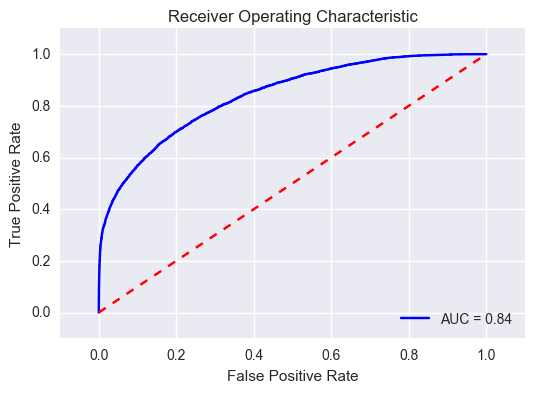

In [43]:
#from @motuai10
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test_enc, predicted_probs)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [46]:
Y_pred_30 = predicted_probs >= .30
print(classification_report(Y_test_enc, Y_pred_30, digits=3))

             precision    recall  f1-score   support

      False      0.881     0.864     0.872     25968
       True      0.584     0.621     0.602      8006

avg / total      0.811     0.806     0.808     33974



We now recall 62% of true positives - much better than 37%!   

Only 58% of our positives actually have diabetes, but that seems like an acceptable trade-off from a medical standpoint; it's OK to spend a little extra time checking on these people if they more likely than not have diabetes. 

### Bonus 2 - LightGBM

I originally wrote this notebook in Summer 2016, and since then, LightGBM has risen to prominence as a faster and often more accurate alternative to XGBoost. By using binning, it can typically run 5-15x faster, and XGBoost is already quite fast. 

In [153]:
# Start by using CV to get rounds for a quicker-training model.
import lightgbm as lgb

lgb_params = {
    'learning_rate': 0.1,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['rmse', 'auc'],
    'num_leaves': 31,
    'max_depth':-1,
    'n_estimators':2000,
    'max_bin':255,
    'min_split_gain':0,
    'min_child_weight':5,
    'min_child_samples':30,
    'subsample':.8,
    'subsample_freq':1,
    'colsample_bytree':.8,
    'reg_alpha':0,
    'reg_lambda':0,
    'seed':0,
    'nthread':-1,
    'verbose': 20
}

lgb_train = lgb.Dataset(X_train_enc, Y_train_enc)
# lgb_eval = lgb.Dataset(???, reference=lgb_train)


OSError: dlopen(/Users/jan/anaconda/lib/python2.7/site-packages/lightgbm-0.1-py2.7.egg/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/gcc/lib/gcc/6/libgomp.1.dylib
  Referenced from: /Users/jan/anaconda/lib/python2.7/site-packages/lightgbm-0.1-py2.7.egg/lightgbm/lib_lightgbm.so
  Reason: image not found

In [ ]:
# CV for lgbm
# Using log vals to simulate eval metric
cv_result = lgb.cv(
lgb_params, 
lgb_train, 
nfold=10,
num_boost_round=2000, 
early_stopping_rounds=20,
verbose_eval=True, 
show_stdv=False,
seed=2001
)


In [ ]:
# Set number of boost rds w/ CV result
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
if cv_result:
    rds = len(cv_result)
    print('num rds from cv = %i' % rds)
else:
    rds = 1050
    print('rds manually set to %i' % rds)

In [ ]:
# TODO: LightGBM

# Tune w/ random search, 10-fold CV, 
